## before/after taxi comparisons
uber goes live in NYC in May 2011, so assuming 2010 is the last FULL year not affected by Uber, let's compare that with the most recent year that we have data (in the same format that is...) - 2016

In [109]:
import csv
import pandas as pd
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
import geopy
import zipcodes
from time import sleep
from statistics import mean
from geopy.extra.rate_limiter import RateLimiter
from mpl_toolkits.basemap import Basemap
from sodapy import Socrata
import operator

let's do a preliminary sanity check of our intuition that the total # of taxi trips will decrease from 2010 to current....

Text(0, 0.5, 'Number of trips')

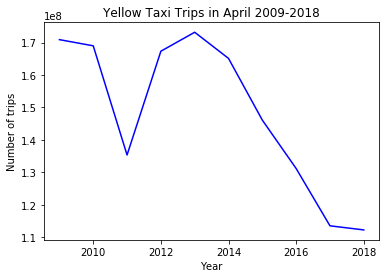

In [11]:
# rip hard coding in the # of trips 
num_trips = [170896055,168994353, 135335924,167331308,173179759,165114361,146087462,131165043, 113496874, 112234626]
year = range(2009,2019)
plt.figure()
plt.plot(year, num_trips, 'b-')
plt.title("Yellow Taxi Trips in April 2009-2018")
plt.xlabel("Year")
plt.ylabel("Number of trips")

So we see from just total trip data that taxi decline started arounnd 2014 (assuming that 2011 was an anomaly - or tbh was it? seeing as Uber went live in 2011 and that taxi usage reacted fast enough)

In [13]:
# scrapin first million trip data from april 2010 and april 2018
# these are found here: https://dev.socrata.com/foundry/data.cityofnewyork.us/74wj-s5ij
# https://dev.socrata.com/foundry/data.cityofnewyork.us/uacg-pexx
client = Socrata("data.cityofnewyork.us", None)
results10 = client.get("74wj-s5ij",where="tpep_pickup_datetime between '2010-04-01T00:00:00' and '2010-04-30T23:59:59'", limit=1000000)
taxi_2010 = pd.DataFrame.from_records(results10)
results16 = client.get("uacg-pexx", where="tpep_pickup_datetime between '2016-04-01T00:00:00' and '2016-04-30T23:59:59'", limit=1000000)
taxi_2016 = pd.DataFrame.from_records(results16)

In [15]:
taxi_2016

,dropoff_latitude,dropoff_longitude,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_longitude,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid
0,40.751319885253906,-73.990676879882813,0.5,8.5,0.3,0.5,2,2,40.758869171142578,-73.979202270507812,1,N,0,0,9.8,2016-04-01T00:10:41.000,2016-04-01T00:00:00.000,0.96,2
1,40.751186370849609,-73.990829467773437,0.5,8.5,0.3,0.5,5,1,40.767723083496094,-73.984855651855469,1,N,1.96,0,11.76,2016-04-01T00:10:30.000,2016-04-01T00:00:00.000,1.54,2
2,40.775283813476563,-73.976814270019531,0,34,0.3,0.5,2,1,40.76947021484375,-73.863739013671875,1,N,8.07,5.54,48.41,2016-04-01T00:00:00.000,2016-04-01T00:00:00.000,10.45,2
3,40.732658386230469,-73.989288330078125,0.5,10,0.3,0.5,2,1,40.757293701171875,-73.985206604003906,1,N,2.25,0,13.55,2016-04-01T00:12:07.000,2016-04-01T00:00:00.000,2.2,1
4,40.753902435302734,-73.977668762207031,0.5,3.5,0.3,0.5,1,2,40.758495330810547,-73.976882934570313,1,N,0,0,4.8,2016-04-01T00:01:59.000,2016-04-01T00:00:00.000,0.5,1
5,40.667373657226563,-73.793914794921875,0.5,13.5,0.3,0.5,1,2,40.647083282470703,-73.790092468261719,1,N,0,0,14.8,2016-04-01T00:08:10.000,2016-04-01T00:00:01.000,4.4,1
6,40.738445281982422,-73.9918212890625,0.5,4.5,0.3,0.5,1,1,40.745426177978516,-73.988899230957031,1,N,1.15,0,6.95,2016-04-01T00:03:46.000,2016-04-01T00:00:01.000,0.6,1
7,40.755081176757813,-73.98565673828125,0.5,4.5,0.3,0.5,2,1,40.747364044189453,-73.985275268554688,1,N,1,0,6.8,2016-04-01T00:03:27.000,2016-04-01T00:00:01.000,0.81,2
8,40.766304016113281,-73.9334716796875,0.5,14,0.3,0.5,1,1,40.757076263427734,-73.973373413085937,1,N,3,0,18.3,2016-04-01T00:15:04.000,2016-04-01T00:00:01.000,3.5,1
9,40.663211822509766,-73.949203491210938,0.5,30.5,0.3,0.5,3,1,40.744110107421875,-73.995780944824219,1,N,7.95,0,39.75,2016-04-01T00:36:59.000,2016-04-01T00:00:02.000,8.48,2


In [100]:
# create DiGraph using k-means clustering --> this time including destination edges! 
def createDiGraphK2(data, sample_size=None, k=40, iters=40, name='k2-taxi'):
    # cluster data using k-means
    print("finding outliers")
    pvalid_idx = np.array(getOutliers(data.pickup_latitude.astype(float), data.pickup_longitude.astype(float), 1))
    dvalid_idx = np.array(getOutliers(data.dropoff_latitude.astype(float), data.dropoff_longitude.astype(float), 1))
    valid_idx = np.intersect1d(pvalid_idx, dvalid_idx)
    print("removing outliers")
    plat = np.array(data.pickup_latitude.astype(float))
    plat = plat[valid_idx]
    plon = np.array(data.pickup_longitude.astype(float))
    plon = plon[valid_idx]
    dlat = np.array(data.dropoff_latitude.astype(float))
    dlat = dlat[valid_idx]
    dlon = np.array(data.dropoff_longitude.astype(float))
    dlon = dlon[valid_idx]
    print("clustering with k-means")
    coordinates= np.array(list(zip(plat, plon)) + list(zip(dlat, dlon)))
    coordinates = coordinates
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    
    
    # create graph with k nodes
    print("creating graph now")
    G = nx.DiGraph(); 
    if sample_size is None: 
        sample_size = len(data)
    for trip_num in range(sample_size):
        
        # get k-means centroid from src and dest
        rand_idx = random.randint(0, len(plat) - 1)
        pla = plat[rand_idx]
        plo = plon[rand_idx]
        dla = dlat[rand_idx]
        dlo = dlon[rand_idx]
        src = labels[rand_idx]
        dest = labels[rand_idx + len(plat)]

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        
        # keep a running average of lat/lon of each node
        G.node[src]['lat'] = (G.node[src]['lat'] +  pla) / 2 
        G.node[src]['lon'] =  (G.node[src]['lon'] +  plo) / 2
        G.node[dest]['lat'] = (G.node[dest]['lat'] +  dla) / 2 
        G.node[dest]['lon'] =  (G.node[dest]['lon'] +  dlo) / 2
        
        # save graph every 1000 nodes
        if (trip_num > 2000 and trip_num % 2000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [90]:
# return indices of valid points
def getOutliers(x, y, outlierConstant):
    a = np.array(x)
    b = np.array(y)
    upper_quartile_a = np.percentile(a, 75)
    lower_quartile_a = np.percentile(a, 25)
    upper_quartile_b = np.percentile(b, 75)
    lower_quartile_b = np.percentile(b, 25)
    IQR_a = (upper_quartile_a - lower_quartile_a) * outlierConstant
    IQR_b = (upper_quartile_b - lower_quartile_b) * outlierConstant
    quartileSet_a = (lower_quartile_a - IQR_a, upper_quartile_a + IQR_a)
    quartileSet_b = (lower_quartile_b - IQR_b, upper_quartile_b + IQR_b)
    valid = []
    for i,v in enumerate(a.tolist()):
        if (v >= quartileSet_a[0] and v <= quartileSet_a[1] and b[i] >= quartileSet_b[0] and b[i] <= quartileSet_b[1]):
            valid.append(i)
    return valid

In [101]:
t11 = createDiGraphK2(taxi_2010, name='k2-taxi-11')

finding outliers
removing outliers
clustering with k-means
creating graph now


In [102]:
t16 = createDiGraphK2(taxi_2016, name='k2-taxi-16')

finding outliers
removing outliers
clustering with k-means
creating graph now


In [94]:
# get coordinates of boundaries of basemap 
def get_coords(G, pad=0.01):
    # scale graph 
    node_lt = nx.get_node_attributes(G, 'lat').values()
    node_ln = nx.get_node_attributes(G, 'lon').values()
    c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]
    return c2

In [95]:
# get map coordinates from lat/long coordinates
def get_pos(G, m):
    pos = {}
    lt = nx.get_node_attributes(G, 'lat')
    ln = nx.get_node_attributes(G, 'lon')
    for node_num in list(G.nodes()):
        pos[node_num] = m(ln[node_num], lt[node_num]) # KEEP IN MIND THIS IS NOW X,Y
    return pos

In [119]:
def compare_graphs(G1, G2, coords=None, node_size=600, draw_edges=True):
    plt.figure(figsize=(16,8))
    if coords is None:
        coords = get_coords(G1) # orient map in terms of first graph
    print(coords)
    # jess apologizes greatly for this crappy copy-paste code
    plt.subplot(1,2,1)
    m1 = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m1.drawcoastlines()
    m1.drawstates()
    m1.fillcontinents(color='blanchedalmond',lake_color='aqua')
    pos1 = get_pos(G1, m1)
    
    # create networkx graph 
    print("CALCULATING RELATIVE WEIGHTS\n")
    cmap = plt.cm.Blues
    c_weights = get_weighted_nodes2(G1, G2, 1.0)
    sz_weights = get_weighted_nodes2(G1, G2, node_size)
    print("FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1\n")
    nx.draw_networkx_nodes(G = G1, pos = pos1, node_color = c_weights[0], alpha=0.8,
                           node_size=sz_weights[0], cmap=cmap)
    if draw_edges:
        nx.draw_networkx_edges(G = G1, pos = pos1, edge_color='white', alpha=0.8, arrows = True)
        
    for file, name in shapefiles.items():
        m1.readshapefile(file, name)
    
    # START MAP 2 STUFF
    plt.subplot(1,2,2)
    print("FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2\n")
    m2 = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m2.drawcoastlines()
    m2.drawstates()
    m2.fillcontinents(color='blanchedalmond',lake_color='aqua')
    pos2 = get_pos(G2, m2)
    nx.draw_networkx_nodes(G = G2, pos = pos2, node_color = c_weights[1], alpha=0.8,
                           node_size=sz_weights[1], cmap=cmap)
    if draw_edges:
        nx.draw_networkx_edges(G = G1, pos = pos1, edge_color='black', alpha=0.8, arrows = True)
        nx.draw_networkx_edges(G = G2, pos = pos2, edge_color='black', alpha=0.8, arrows = True)
        
    # read in shapefiles to project on top of map 
    for file, name in shapefiles.items():
        m2.readshapefile(file, name)
        
    # set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    plt.show()
    return [m1, m2]

In [122]:
def get_weighted_nodes2(G1, G2, ref):
    # get weights into the range [0.5-1]
    range_offset=1.0
    out_raw1 = dict(G1.out_degree(weight='weight'))
    out_raw2 = dict(G2.out_degree(weight='weight'))
    min_out = min(min(out_raw1.values()), min(out_raw2.values()))
    max_out = max(max(out_raw1.values()), max(out_raw2.values()))
    out_weights1 = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw1.items()}
    out_weights2 = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw2.items()}
    
    # adjust sizing of nodes based on their relative out-degrees
    sizes = [[],[]]
    for node in list(G1.nodes()):
        sizes[0].append(ref*range_offset*(out_weights1[node]))
    for node in list(G2.nodes()):
        #sizes[1].append(ref*0.5*(out_weights2[node]) + 0.5*ref)
        sizes[1].append(ref*range_offset*(out_weights2[node]))
    return sizes

[40.69969667379978, 40.80590031847515, -74.02603439666909, -73.93708693750683]
CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



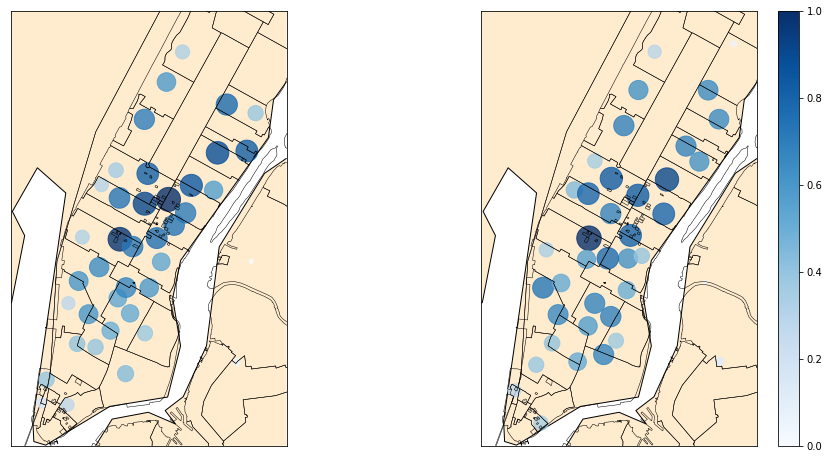

In [123]:
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
m = compare_graphs(t11, t16, draw_edges=False)

Text(0.5, 1.0, 'Relative weights of each cluster')

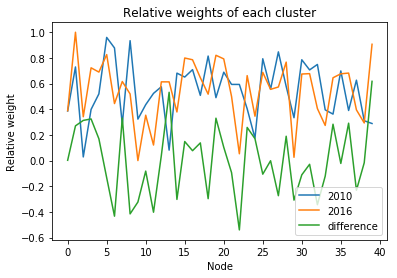

In [210]:
rel_weights = get_weighted_nodes2(t11, t16, 1.0)
num_nodes = len(rel_weights[0])
x = range(0, num_nodes)
plt.figure()
plt.plot(x, rel_weights[0], label='2010')
plt.plot(x, rel_weights[1], label='2016')
diff = [a-b for a, b in zip(rel_weights[1], rel_weights[0])]
plt.plot(x, diff, label='difference')
plt.legend(loc='best')
plt.xlabel("Node")
plt.ylabel("Relative weight")
plt.title("Relative weights of each cluster")

In [211]:
mean(diff)

7.632783294297952e-18

## let's try to actually do something with the edges now!!!

In [116]:
nx.write_graphml(t11, "graphs/taxi-2011-all.graphml")
nx.write_graphml(t16, "graphs/taxi-2016-all.graphml")

In [115]:
m[0]

In [117]:
t10_small = createDiGraphK2(taxi_2010, sample_size=1000, name='k2-taxi-10-small')
t16_small = createDiGraphK2(taxi_2016, sample_size=1000, name='k2-taxi-16-small')

finding outliers
removing outliers
clustering with k-means
creating graph now
finding outliers
removing outliers
clustering with k-means
creating graph now


[40.69969667379978, 40.80590031847515, -74.02603439666909, -73.93708693750683]
CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



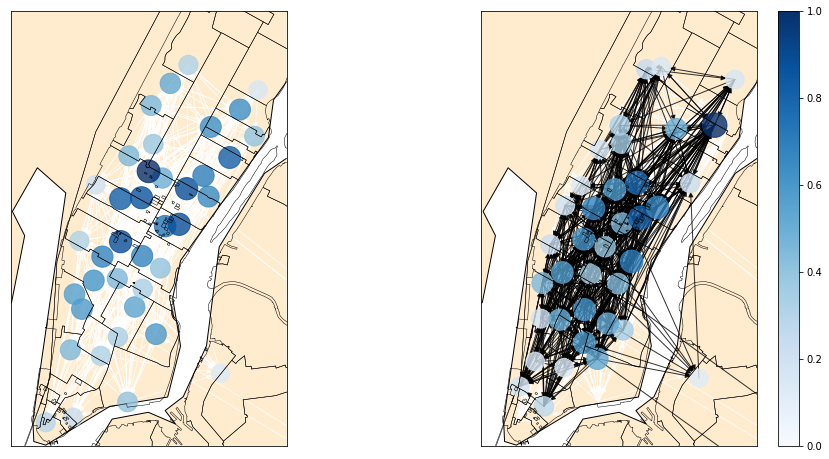

In [121]:
c = [40.69969667379978, 40.80590031847515, -74.02603439666909, -73.93708693750683]
m_small = compare_graphs(t10_small, t16_small, coords=c)

In [203]:
# LOOK INTO THIS FNC SO YOU AVOIDTHIS UGLY ASS CODE - edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
def get_weighted_edges(t11, ref):
    ew = nx.get_edge_attributes(t11, 'weight')
    max_w = max(ew.values())
    edge1, weights1 = zip(*nx.get_edge_attributes(t11,'weight').items())
    thres = np.quantile(np.array(weights1), .75) # only get edges > upper quartile
    edgelist = [e for e in edge1 if ew[e] > thres]
    edgeweights = [ew[e] for e in edgelist]
    return [edgelist, edgeweights]
    

In [206]:
def compare_graphsE(G1, G2, coords=None, node_size=600, draw_edges=True):
    plt.figure(figsize=(16,8))
    if coords is None:
        coords = get_coords(G1) # orient map in terms of first graph
    print(coords)
    # jess apologizes greatly for this crappy copy-paste code
    plt.subplot(1,2,1)
    m1 = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m1.drawcoastlines()
    m1.drawstates()
    m1.fillcontinents(color='blanchedalmond',lake_color='aqua')
    pos1 = get_pos(G1, m1)
    
    # create networkx graph 
    print("CALCULATING RELATIVE WEIGHTS\n")
    cmap = plt.cm.Blues
    c_weights = get_weighted_nodes2(G1, G2, 1.0)
    sz_weights = get_weighted_nodes2(G1, G2, node_size)
    print("FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1\n")
    nx.draw_networkx_nodes(G = G1, pos = pos1, node_color = c_weights[0], alpha=0.8,
                           node_size=sz_weights[0], cmap=cmap)
    if draw_edges:
        edgelist, edgeweights = get_weighted_edges(G1, 1.0)
        nx.draw_networkx_edges(G = G1, pos = pos1, edgelist=edgelist, edge_color=edgeweights, alpha=0.5, arrows = True, cmap=plt.cm.Greys)

    for file, name in shapefiles.items():
        m1.readshapefile(file, name)
        
    # START MAP 2 STUFF
    plt.subplot(1,2,2)
    print("FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2\n")
    m2 = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m2.drawcoastlines()
    m2.drawstates()
    m2.fillcontinents(color='blanchedalmond',lake_color='aqua')
    pos2 = get_pos(G2, m2)
    nx.draw_networkx_nodes(G = G2, pos = pos2, node_color = c_weights[1], alpha=0.8,
                           node_size=sz_weights[1], cmap=cmap)
    if draw_edges:
        edgelist, edgeweights = get_weighted_edges(G2, 1.0)
        nx.draw_networkx_edges(G = G2, pos = pos2, edgelist=edgelist, edge_color=edgeweights, alpha=0.5, arrows = True, cmap=plt.cm.Greys)
        
    # read in shapefiles to project on top of map 
    for file, name in shapefiles.items():
        m2.readshapefile(file, name)
        
    # set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    plt.show()
    return [m1, m2]

[40.69969667379978, 40.80590031847515, -74.02603439666909, -73.93708693750683]
CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



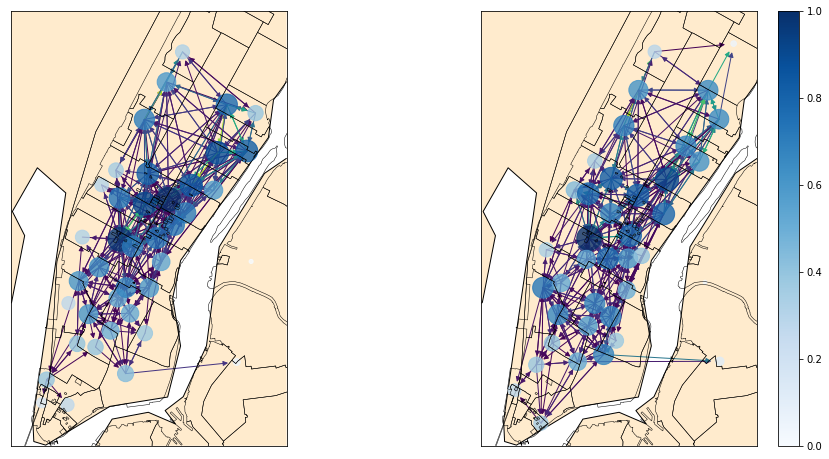

In [207]:
mE = compare_graphsE(t11, t16, coords=c)

In [182]:
# compare  out/in-degrees? 
out_raw0 = dict(t11.out_degree(weight='weight'))
out_raw6 = dict(t16.out_degree(weight='weight'))
in_raw0 =dict(t11.in_degree(weight='weight'))
in_raw6 = dict(t16.out_degree(weight='weight'))

Text(0, 0.5, 'Degree')

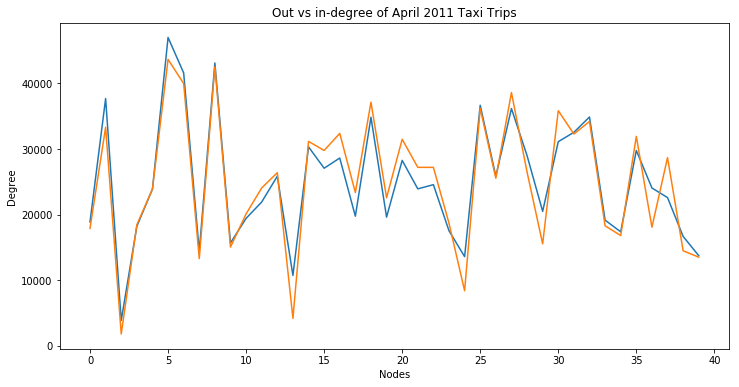

In [209]:
nodes = range(0,40)
plt.figure(figsize=(12,6))
plt.plot(nodes, in_raw0.values(), nodes, out_raw0.values())
plt.title("Out vs in-degree of April 2011 Taxi Trips")
plt.xlabel("Nodes")
plt.ylabel("Degree")